In [132]:
import numpy as np
import os
import re
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from operator import itemgetter

from immstools.dataset import dataset, fitParaAsDict
from immstools.plotting import mobilogram
from immstools.fitmodels import ATDMultiGauss, TwoStatesExpDecayModel

######### This cell should be run after restart or to reset the k values stored in kdict with the temperatures

# to store rates and temperatures
kdict = {}

def sigmoid(x,x0, k):
    return 1 / (1 + np.exp(-k*(x-x0)))

## Read data from IMS/IMS trap and release experiment
Read a series of ATDs recorded after different trapping time and fits peaks by Gaussians. The time evolution of the relative intensity of the peak initially selected is then fitted using an exponential decay model.
The initial and asymptotic values of the relative population can be fixed or let as a free parameter.

Notice: 
- running the first section will reset the values of the isomerization rates determined from previous datasets.
- in order to keep previous k values, the Temperature variable has to be changed. This Temperature value is used further for the Eyring plot and should then correspond to the experimental temperature in Celcius.


reading NspeNspeN2tzNspe_H_T187_s14.3_d10.0_600V_2023125.hdf5...
Trap Delay = 10.0
from metadata, T= 187.0
##############################
Fit with 2 Gaussians.
* peak0	@16.92 ms, sig=0.17 ms, A=48437.1
* peak1	@17.68 ms, sig=0.27 ms, A=12449.1
baseline y0=2078.17
xshift =-0.04
R² = 0.998
Normality of the residuals - p_value = 7.51%
##############################


reading NspeNspeN2tzNspe_H_T187_s14.3_d30.0_600V_2023125.hdf5...
Trap Delay = 30.0
from metadata, T= 187.0
##############################
Fit with 2 Gaussians.
* peak0	@16.89 ms, sig=0.17 ms, A=29899.1
* peak1	@17.69 ms, sig=0.25 ms, A=20462.0
baseline y0=1841.82
xshift =-0.02
R² = 0.997
Normality of the residuals - p_value = 53.05%
##############################


reading NspeNspeN2tzNspe_H_T187_s14.3_d50.0_600V_2023125.hdf5...
Trap Delay = 50.0
from metadata, T= 187.0
##############################
Fit with 2 Gaussians.
* peak0	@16.89 ms, sig=0.17 ms, A=20914.8
* peak1	@17.71 ms, sig=0.24 ms, A=27906.1
baseline y0=651.72
x

C:\Users\manip-spectrobio\AppData\Local\Temp\ipykernel_11628\929693393.py:99: RuntimeWarning: invalid value encountered in divide
  relativeIntensities = intensities/intensities.sum(axis=0)


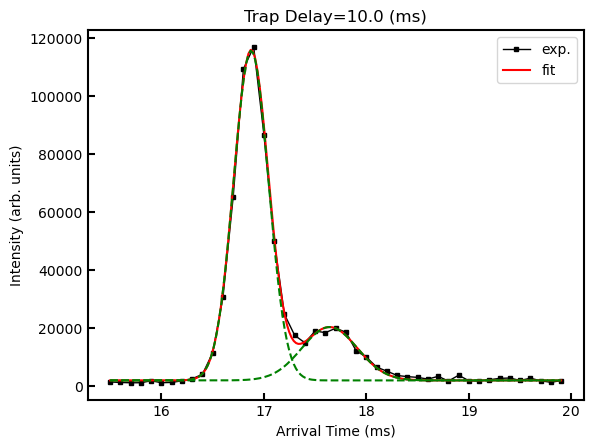

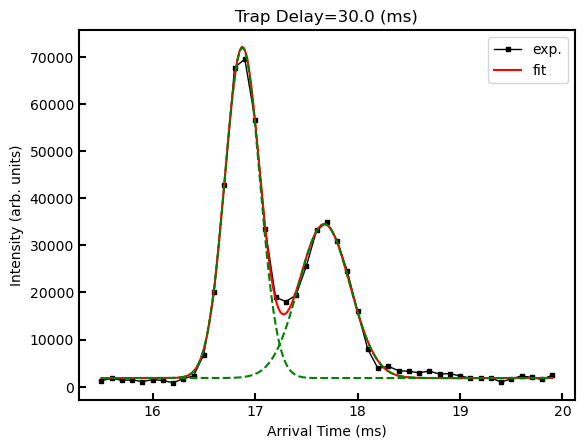

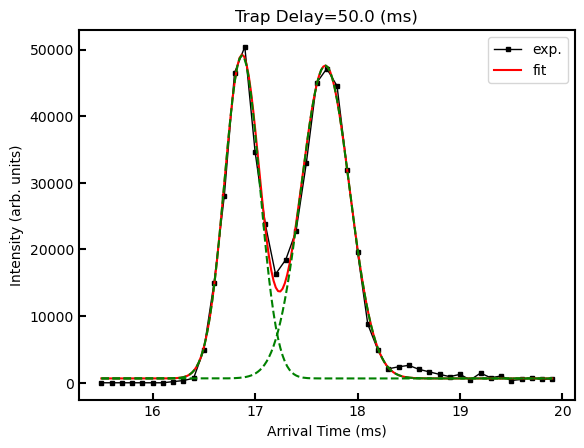

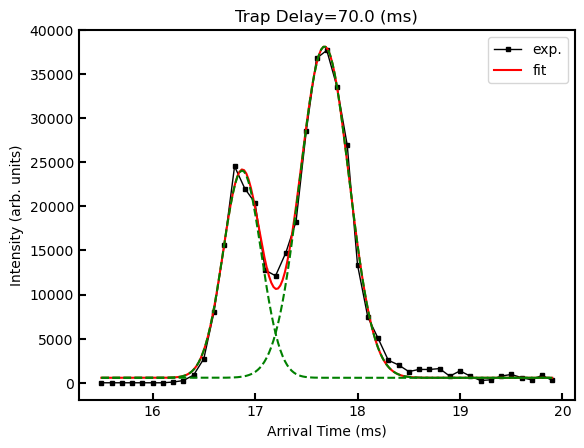

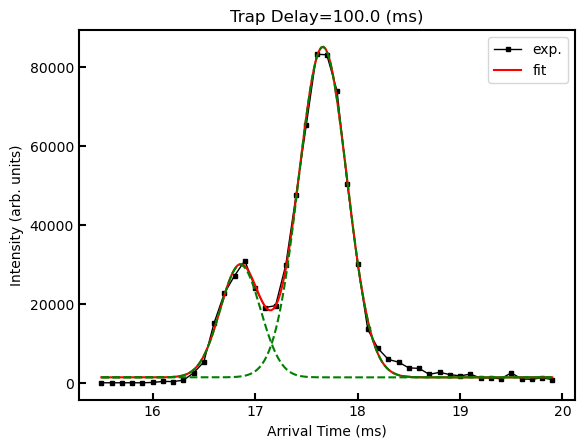

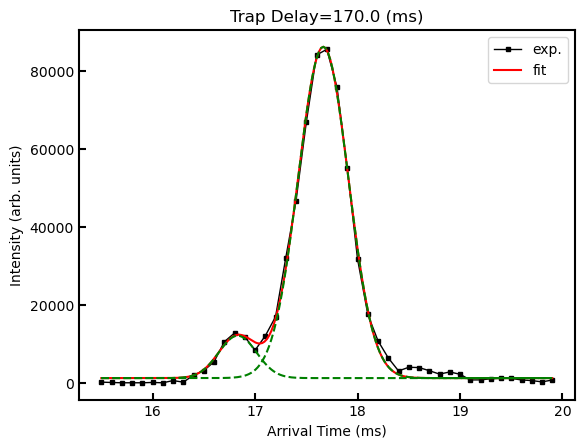

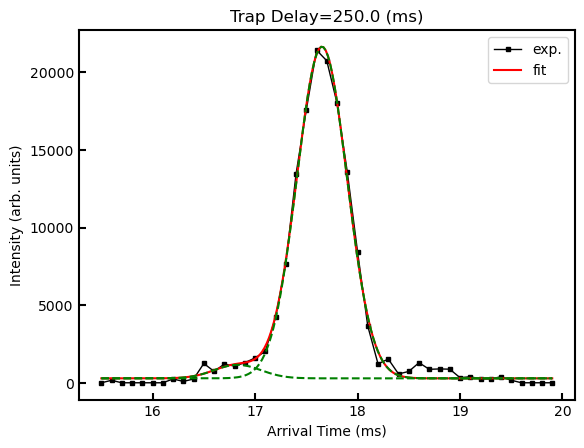

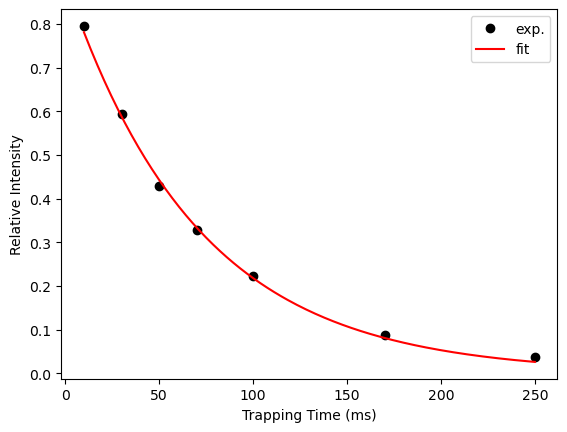

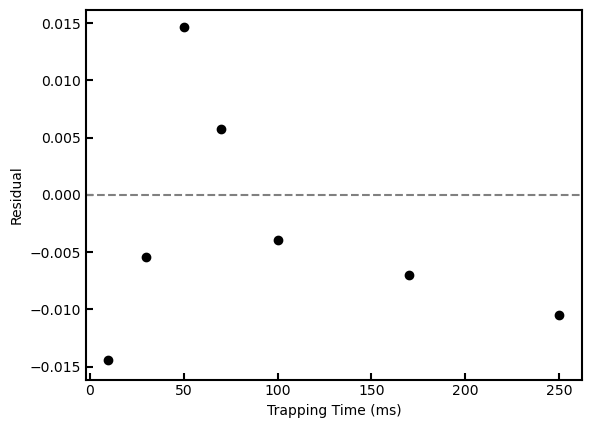

{'T187.0': {'T': 187.0, 'dT': 2.0, 'k': 0.014173323195439489, 'dk': 0.00022847875328771324}, 'T199.0': {'T': 199.0, 'dT': 2.0, 'k': 0.029232236209055282, 'dk': 0.0005996155290277226}, 'T224.0': {'T': 224.0, 'dT': 2.0, 'k': 0.10396764064309479, 'dk': 0.003834693994442194}, 'T177.0': {'T': 177.0, 'dT': 2.0, 'k': 0.009115396951692256, 'dk': 0.00027132227323248135}, 'T167.0': {'T': 167.0, 'dT': 2.0, 'k': 0.0052759524164727135, 'dk': 8.784292559635395e-05}, 'T211.0': {'T': 211.0, 'dT': 2.0, 'k': 0.05418866617847818, 'dk': 0.0006041966405958388}}


In [126]:
## define parameters
# Set the diectory in which the datafiles are stored
WDIR = r"C:\Users\manip-spectrobio\Documents\DATA\AzoMons\NspeNspeN2tzNspe_H\T187"  
startswith = "N" # only files begining with this string will be considered

# this is the experimental temperature in °C
Temperature = 187.0

# this is the position of the peaks to fit by Gaussians
# the first value is assumed to be the selected peak
peaks = [16.9, 17.7]

# this is m/z the range on which the ATDs will be extracted
mzRange=[745, 748]

# this is the arrival time range on which the fit will be performed, set to None for full ATD
tdRange=[15.5, 20.0]

parameter =  'Trap Delay'  # This is the parameter that changes between the dataset, set to 'Trap Delay' for kinetics exp.
parameter_unit = 'ms'

do_plot_fits = True
# Chose True to plot all ATDs and fitted curves

######### Nothing should be changed after this point

parameter_label = parameter + " (" + parameter_unit + ")"

## list datafiles
if startswith == "":
    FILELIST = os.listdir(WDIR)
else:
    FILELIST = [f for f in os.listdir(WDIR) if f.startswith(startswith)]

# order the list by increasing value of the parameter
parvals = np.zeros(len(FILELIST))
# first sort FILELIST in increasing order of the trapping times
for ii, fn in enumerate(FILELIST):
    # read
    # print("\nreading {}...".format(fn))
    D = dataset(os.path.join(WDIR, fn))
    param_value = D.getParamValue(parameter)

    parvals[ii] = param_value


# sorts the tables with respect to the delays
tab = np.array(list(zip(*sorted(zip(parvals,FILELIST), key=itemgetter(0)))))

levels = np.array(list(map(float,tab[0])))    # sorted param_value table
filelist = tab[1]   # filelist table sorted as a function of parameter

npeaks = len(peaks)
nlevels = len(levels)

## Fit the peaks in the ATDs

intensities = np.zeros((npeaks, nlevels))

for ii, fn in enumerate(filelist):
    # read
    print("\nreading {}...".format(fn))
    D = dataset(os.path.join(WDIR, fn))

    print(parameter, "=", levels[ii])
    try:
        print("from metadata, T=", D["Temp"])
    except NameError:
        print("No temperature information in metadata.")
        print(D.metadata)

    # fit peaks
    F = ATDMultiGauss(peaks,
    sigmas=0.22,
    xtol = 0.05,
    stol=0.05,
    xshift=True,
    maxshift=0.05)

    F.fitData(D,
    mzRange=mzRange,
    tdRange=tdRange)
    
    if do_plot_fits:
        print(F.fitSummary())
    if not(F.success):
        continue

    # store intensities
    for pk in range(npeaks):
        intensities[pk][ii] = F.amplitudes[pk]

    relativeIntensities = intensities/intensities.sum(axis=0)

    if do_plot_fits:
        fig, ax = plt.subplots(num="{}={} ({})".format(parameter, levels[ii], parameter_unit))
        F.plotFit(ax)
        ax.set_title("{}={} ({})".format(parameter, levels[ii], parameter_unit))
        
## exponential fit of the selected peak intensity
ytoFit = relativeIntensities[0]
if len(ytoFit) > 2:
    
    Xp = TwoStatesExpDecayModel(R0=1.0, Rinf=0.0, postDecay=0.90)
    Xp.fitData(levels,ytoFit)
    print(Xp.fitSummary())

    Xp.plotFit()
    Xp.plotResiduals()
    plt.show()
    
    # store the result
    kdict["T{:.1f}".format(Temperature)] = {"T": Temperature, "dT":2.0, "k": Xp.kobs, "dk": Xp.kobs_std}

print(kdict)

## Eyring's plot
Uses Eyring's equation to fit the evolution of the isomerization rate $k$ as a function of the temperature $T$:
$$ \ln\frac{k}{T} = \ln\frac{k_{B}}{h} + \frac{\Delta S^{\ddagger} }{R} - \frac{\Delta H^{\ddagger}}{R} $$
and derives $\Delta H^{\ddagger}$ and $\Delta S^{\ddagger}$ from a linear fit.

6 Rates stored at different temperatures.


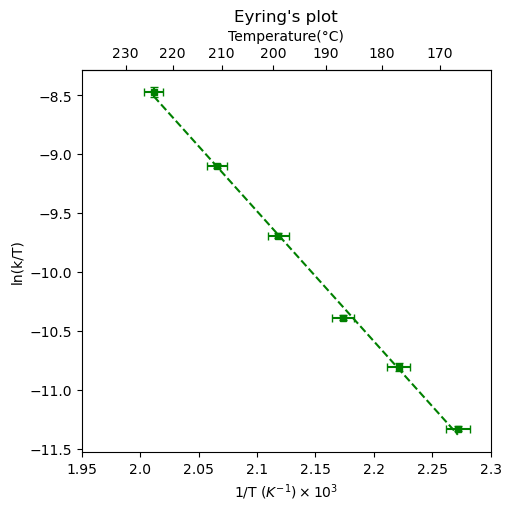

Fit R²= 0.9988563587252158

DH# = 91.73 ± 2.20 kJ/mol
DS# = -99.04 ± 4.10 J/mol/K
Errors correspond to the standard deviations from the linear regression

95% confidence intervals:
DH# : [85.63, 97.82] kJ/mol
DS# : [-110.42, -87.65] J/mol/K


In [127]:
from operator import itemgetter
from scipy import stats

print(len(kdict), "Rates stored at different temperatures.")

# extract lists to be exploited as an Eyring plot
k = []
T = []
if len(kdict) >= 3:
    for kd in kdict.values():
        T.append(kd["T"])
        k.append([kd["k"], kd["dk"]])
k = np.array(k)      
T = np.array(T)
# sort in increasing order of the temperatures
tab = list(zip(*sorted(zip(T,k), key=itemgetter(0))))

T = np.array(tab[0]) + 273.15
k = np.array(tab[1])
dk = k[:,1]
k = k[:,0]
dT = np.ones_like(T)*2.0

# stats for regressions
# nb degrees of freedom and Student t for the confidence intervals
confidence = 0.95
N = len(k)
DDL = N-2
talpha = stats.t.interval(confidence, DDL)[1]

# Eyring's quantities
invT = 1.0/T
dinvT = invT*dT/T

logkT = np.log(k/T)
dlogkT = dT/T + dk/k

# Fit
result = stats.linregress(invT, logkT)
slope = result.slope
intercept = result.intercept
std_err = result.stderr
intercept_stderr = result.intercept_stderr

# Eyring's plot
def iT2C(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)

    return 1.0/(x)-273.15


def C2iT(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)

    return 1.0/(x+273.15)

xfit = np.linspace(np.min(invT), np.max(invT))
fig, ax1 = plt.subplots(1,1,figsize=(5, 5), layout='constrained')
ax1.errorbar(invT, logkT, dlogkT, dinvT, 'sg', markersize=5, capsize=3)
ax1.plot(xfit, slope*xfit+intercept, '--g')

ax2 = ax1.secondary_xaxis('top', functions=(iT2C, C2iT))
ax2.set_xlabel("Temperature(°C)")

# multiply the axes values by 1000 for display
ax1.set_xticks(ticks=ax1.get_xticks(), labels=np.round(1000.0 * np.array(ax1.get_xticks(), dtype=np.float64),2))

ax1.set_title("Eyring\'s plot")
ax1.set_ylabel('ln(k/T)') 
ax1.set_xlabel(r'1/T $(K^{-1}) \times 10^{3}$')

plt.show()

# compute transition state characteristics
lnkB_sur_hbar = 25.5974
DH = -slope*8.314/1000. # kJ/mol
DS = (intercept-lnkB_sur_hbar)*8.314 # J/mol/K
dDH = np.abs(std_err*8.314/1000.)  #np.abs(std_errX*talpha*8.314/1000.) # conf. interval
dDS = np.abs(DS*intercept_stderr/intercept)  #np.abs(DSx*intercept_stderrX*talpha/interceptX) # conf. interval

print("Fit R²=", np.abs(result.rvalue))
print()
print("DH# = {:.2f} \xB1 {:.2f} kJ/mol".format(DH, dDH))
print("DS# = {:.2f} \xB1 {:.2f} J/mol/K".format(DS, dDS))
print("Errors correspond to the standard deviations from the linear regression")
print()
print("{}% confidence intervals:".format(int(confidence*100)))
dDHc = dDH*talpha
dDSc = dDS*talpha
print("DH# : [{:.2f}, {:.2f}] kJ/mol".format(DH-dDHc, DH+dDHc))
print("DS# : [{:.2f}, {:.2f}] J/mol/K".format(DS-dDSc, DS+dDSc))